# Loading the data set

In [2]:
'''
Import packages 
'''

%matplotlib inline

from sklearn.datasets import fetch_openml # Import MNIST from a Package
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch Imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# We will be using the PyTorch Wrapper Framework skorch to help simplify the coding
from skorch import NeuralNetClassifier
import skorch
from skorch.helper import predefined_split

# We need to import some Sci-kit Learn modules for computation purposes.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Global Settings - These settings are critical

# If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting a seed for torch
torch.manual_seed(0)

In [2]:
'''
Import the data
'''
class DatasetFromSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, index):
        x, y = self.subset[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.subset)

train_transform = transforms.Compose([
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456 ,0.406) ,(0.229 ,0.224 ,0.225))
                                ])

test_transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485 ,0.456 ,0.406) ,(0.229 ,0.224 ,0.225))
                                ])

cifar10 = torchvision.datasets.CIFAR10(root = './data',
                                        train = True,
                                        download = True)

train_subset, validation_subset = torch.utils.data.random_split(cifar10, [40000, 10000])

train_dataset = DatasetFromSubset(train_subset, train_transform)

validation_dataset = DatasetFromSubset(validation_subset, test_transform)

test_dataset = torchvision.datasets.CIFAR10(root = './data', 
                                          train = False, 
                                          transform = test_transform,
                                          download = True)

print(train_dataset[0][0].shape)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 224, 224])


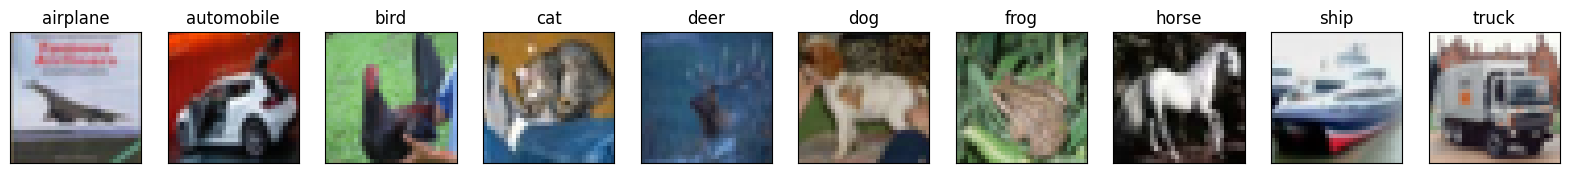

In [7]:
'''
Will do some basic plotting to get a feel for the data that we imported.

'''

classes = cifar10.classes
index_dict = cifar10.class_to_idx
class_index = []

for c in classes:
    index = index_dict[c]
    i = 0
    for im, tar in test_dataset:
        if tar == index:
            class_index.append(i)
            break
        i+=1

class_data = [(test_dataset.data[i], test_dataset.targets[i]) for i in class_index]

def plot_example(data):
    """Plot the first 5 images and their labels in a row."""
    plt.figure(figsize=(20, 20))
    for i, (img, y) in enumerate(data):
        plt.subplot(1, 10, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(classes[y])
    
    

plot_example(class_data)


## Problem 2

tensor([497, 356, 963, 266,  85, 244, 182])
tensor([449, 298, 794, 611,  85, 399,  50])


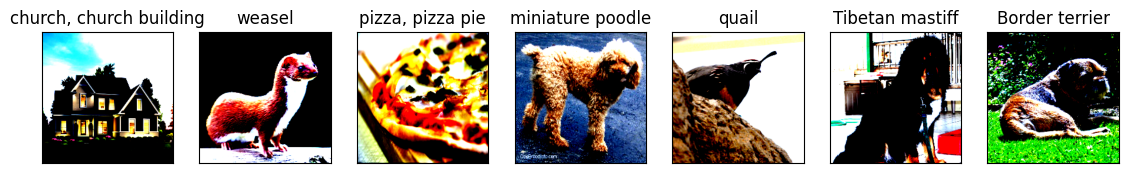

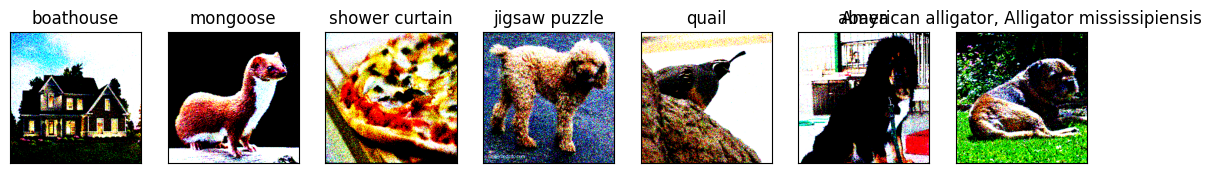

In [9]:
from PIL import Image
import os
# Getting the model

with open('./imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]


resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

imagenet_test = [Image.open(os.path.join('./Test-Images', f)).convert('RGB') for f in os.listdir('./Test-Images')]
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485 ,0.456 ,0.406) ,(0.229 ,0.224 ,0.225))
    ])

imagenet_test_tensor = [to_tensor(i) for i in imagenet_test]
imagenet_test_tensor = torch.stack(imagenet_test_tensor)

resnet18.eval()
y_res = resnet18(imagenet_test_tensor)
y = torch.argmax(y_res, dim=1)
print(y)

plot_example([(torch.clip(imagenet_test_tensor[i].permute(1,2,0), 0,1).numpy(), y[i]) for i in range(len(y))])

# Tricking the model

imagenet_test_tensor = torch.clip(imagenet_test_tensor + torch.randn_like(imagenet_test_tensor)*.4, 0, 1)

y_res = resnet18(imagenet_test_tensor)
y = torch.nn.Softmax(dim=1)(y_res)
y = torch.argmax(y, dim=1)
print(y)

noised = [(imagenet_test_tensor[i].permute(1,2,0).numpy(), y[i]) for i in range(len(y))]
plot_example(noised)





## Problem 3

In [257]:
# Loading Resnet and changing output layer
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(512, 10)
for name, param in resnet18.named_parameters():
    if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False

# Training the model
resnet = NeuralNetClassifier(resnet18,
                            train_split=predefined_split(validation_dataset),
                            criterion=nn.CrossEntropyLoss,
                            optimizer=torch.optim.Adam,
                            lr=0.001,
                            optimizer__weight_decay=0.0001,
                            max_epochs=30,
                            device=device,
                            classes=classes,
                            iterator_train__shuffle=True,
                            iterator_train__num_workers=4,
                            iterator_train__pin_memory=True,
                            iterator_valid__shuffle=False,
                            iterator_valid__num_workers=4,
                            iterator_valid__pin_memory=True,
                            callbacks=[skorch.callbacks.EarlyStopping(monitor='valid_acc', patience=5, threshold=0.01, lower_is_better=False, threshold_mode='abs')])
resnet = resnet.fit(train_dataset, y=None)


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4491       0.7152        0.8696  36.3861
      2        1.1917       0.7492        0.7549  38.2913
      3        1.1636       0.7521        0.7331  39.4819
      4        1.1271       0.7597        0.7159  40.1727
      5        1.1168       0.7579        0.7136  40.7744
      6        1.1154       0.7527        0.7204  39.6773
      7        1.1110       0.7659        0.7000  35.9720
      8        1.0986       0.7589        0.7013  36.1799
Stopping since valid_acc has not improved in the last 5 epochs.


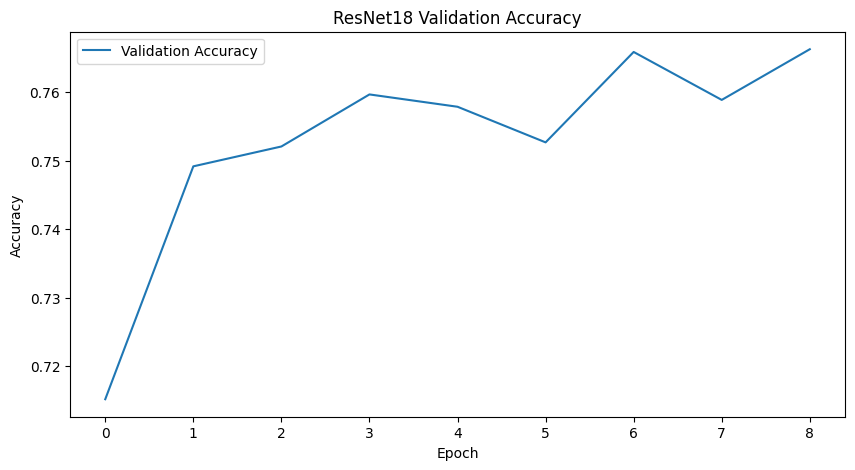

In [258]:
plt.figure(figsize=(10, 5))
plt.plot(resnet.history[:, 'valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 Validation Accuracy')
plt.legend()
plt.show()

In [259]:
# Unfreezing first convolutional layer
resnet18_finetuned = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18_finetuned.fc = nn.Linear(512, 10)
for name, param in resnet18_finetuned.named_parameters():
    if name not in ['fc.weight', 'fc.bias', 'conv1.weight', 'layer1.0.conv1.weight']:
        param.requires_grad = False

# Training the model
resnet_fine = NeuralNetClassifier(resnet18_finetuned,
                            train_split=predefined_split(validation_dataset),
                            criterion=nn.CrossEntropyLoss,
                            optimizer=torch.optim.Adam,
                            lr=0.001,
                            optimizer__weight_decay=0.0001,
                            max_epochs=30,
                            device=device,
                            classes=classes,
                            iterator_train__shuffle=True,
                            iterator_train__num_workers=4,
                            iterator_train__pin_memory=True,
                            iterator_valid__shuffle=False,
                            iterator_valid__num_workers=4,
                            iterator_valid__pin_memory=True,
                            callbacks=[skorch.callbacks.EarlyStopping(monitor='valid_acc', patience=5, threshold=0.01, lower_is_better=False, threshold_mode='abs')])

resnet_fine.fit(train_dataset, y=None)
torch.save(resnet_fine.module.state_dict(), './resnet18_finetuned.pt')


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.4151       0.7504        0.7718  70.9053
      2        1.0967       0.7761        0.6809  70.7957
      3        1.0273       0.8006        0.6096  70.8643
      4        0.9864       0.8123        0.5682  70.9096
      5        0.9707       0.8084        0.5590  70.6903
      6        0.9474       0.8180        0.5344  70.6107
      7        0.9282       0.8135        0.5517  70.6949
      8        0.9190       0.8215        0.5301  70.4843
      9        0.9198       0.8264        0.5224  70.4866
     10        0.9119       0.8219        0.5267  70.4018
     11        0.9008       0.8235        0.5207  70.6132
     12        0.9018       0.8300        0.5083  70.5890
     13        0.8900       0.8342        0.4842  70.6021
Stopping since valid_acc has not improved in the last 5 epochs.


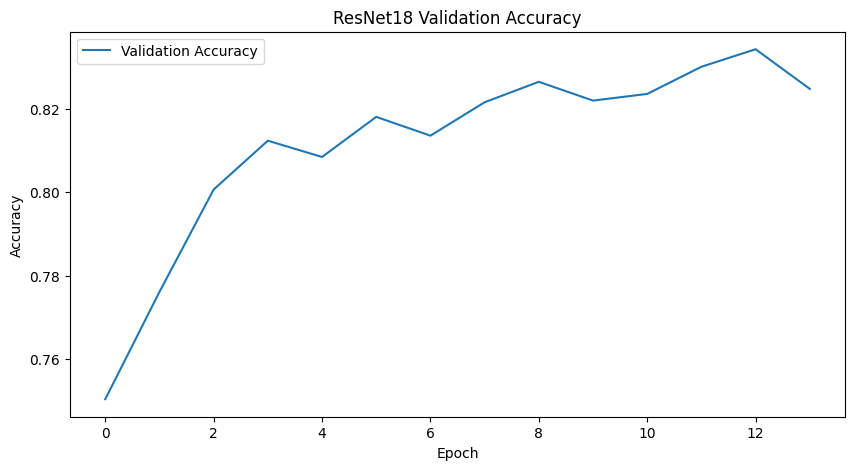

In [262]:
plt.figure(figsize=(10, 5))
plt.plot(resnet_fine.history[:,'valid_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet18 Validation Accuracy')
plt.legend()
plt.show()

torch.Size([64, 3, 7, 7])
torch.Size([64, 3, 7, 7])


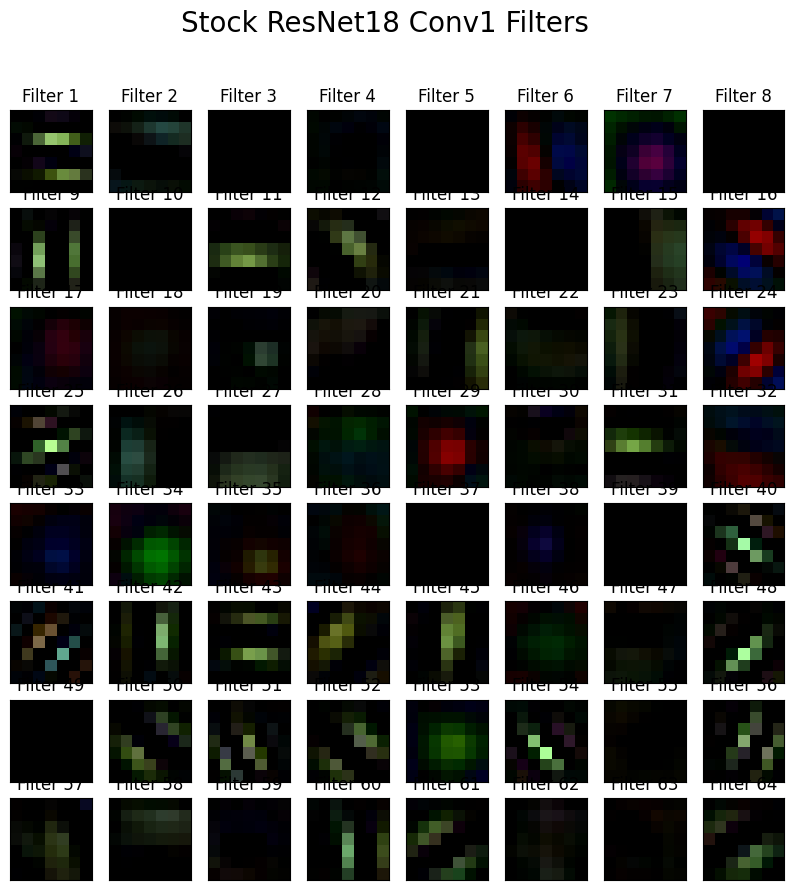

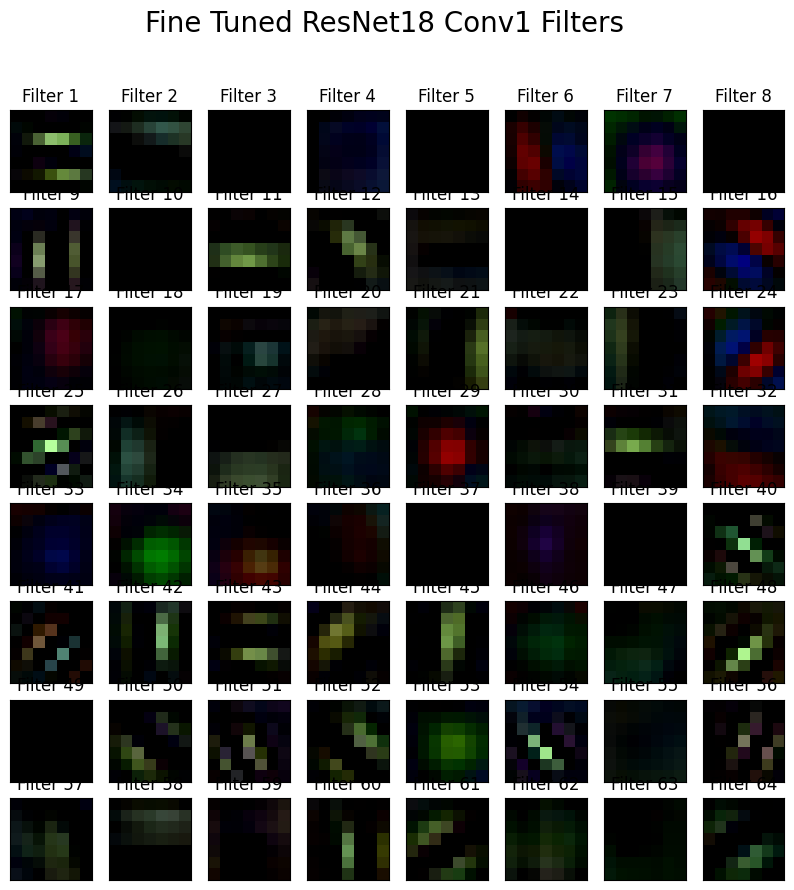

In [3]:
# Getting stock convolutional filters
resnet18_stock = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
conv1_filters = resnet18_stock.conv1.weight.detach().clone()
print(conv1_filters.shape)
print(resnet18_stock.get_parameter('conv1.weight').shape)
conv1_filters = conv1_filters.permute(0,2,3,1).numpy()

# Getting fine tuned convolutional filters

resnet_finetuned = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet_finetuned.fc = nn.Linear(512, 10)
resnet_finetuned.load_state_dict(torch.load('./resnet18_finetuned.pt'))
conv1_filters_finetuned = resnet_finetuned.conv1.weight.detach().clone()
conv1_filters_finetuned = conv1_filters_finetuned.permute(0,2,3,1).numpy()

# Plotting the filters
def plot_filters(filters, title):
    plt.figure(figsize=(10, 10))
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(filters[i].clip(0,1))
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Filter {i+1}')
    plt.suptitle(title, fontsize=20)

plot_filters(conv1_filters, "Stock ResNet18 Conv1 Filters")
plot_filters(conv1_filters_finetuned, "Fine Tuned ResNet18 Conv1 Filters")

